In [1]:
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
import pylab as pl
%pylab inline

In [142]:
# -*- coding: utf-8 -*-
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to http://www.yelp.com/developers/v3/documentation for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= "Your API key"

# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'New York, NY'
SEARCH_LIMIT = 50


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)


def main():
    parser = argparse.ArgumentParser()

    parser.add_argument('-q', '--term', dest='term', default=DEFAULT_TERM,
                        type=str, help='Search term (default: %(default)s)')
    parser.add_argument('-l', '--location', dest='location',
                        default=DEFAULT_LOCATION, type=str,
                        help='Search location (default: %(default)s)')

    input_values = parser.parse_args()

    try:
        query_api(input_values.term, input_values.location)
    except HTTPError as error:
        sys.exit(
            'Encountered HTTP error {0} on {1}:\n {2}\nAbort program.'.format(
                error.code,
                error.url,
                error.read(),
            )
        )


In [37]:
din = search(API_KEY, 'dinner', 'NYC')

Querying https://api.yelp.com/v3/businesses/search ...


In [63]:
lat, lon, name, rating, add, phone = [],[],[],[],[],[]
for i in din['businesses']:
    lat.append(i['coordinates']['latitude'])
    lon.append(i['coordinates']['longitude'])
    name.append(i['name'])
    rating.append(i['rating'])
    add.append(i['location']['display_address'])
    phone.append(i['phone'])

In [56]:
data = pd.DataFrame(columns=['Name', 'Rating', 'Address', 'Phone', 'Latitude', 'Longitude'])

In [64]:
data['Name'] = name
data['Rating'] = rating
data['Address'] = add
data['Phone'] = phone
data['Latitude']= lat
data['Longitude'] = lon

In [116]:
data['geometry'] = (list(zip(data.Longitude, data.Latitude )))
data['geometry'] = data.geometry.apply(lambda x: Point(x))
#data.set_geometry(data['geometry'])

In [117]:
data.head()

,Name,Rating,Address,Phone,Latitude,Longitude,geometry
0,Bea,4.0,"[403 W 43rd St, New York, NY 10036]",+12126021910,40.759197,-73.992336,POINT (-73.9923361 40.7591968)
1,Upstate,4.5,"[95 1st Ave, New York, NY 10003]",+16467915400,40.726314,-73.986490,POINT (-73.9864901976935 40.7263139141197)
2,Anytime,4.5,"[23 W 32nd St, Fl 3, New York, NY 10001]",+16466697733,40.747790,-73.986740,POINT (-73.98674 40.74779)
3,Sugar Momma,4.5,"[15 Cliff St, New York, NY 10038]",+12126029991,40.708370,-74.005630,POINT (-74.00563 40.70837)
4,Amélie,4.5,"[22 W 8th St, New York, NY 10011]",+12125332962,40.732700,-73.997660,POINT (-73.99766 40.7327)


In [103]:
gp = gpd.GeoDataFrame(data, geometry='geometry')

In [126]:
!wget https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip

--2019-02-10 21:26:38--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip’

YObIR0MbpUVA0EpQzZS     [    <=>             ]   1.44M  1.93MB/s    in 0.7s    

2019-02-10 21:26:39 (1.93 MB/s) - ‘YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip’ saved [1514401]



In [127]:
!unzip YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip

Archive:  YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
  inflating: ZIP_CODE_040114.shx     
  inflating: ZIP_CODE_040114.dbf     
  inflating: ZIP_CODE_040114.prj     
  inflating: ZIP_CODE_040114.sbn     
  inflating: ZIP_CODE_040114.sbx     
  inflating: ZIP_CODE_040114.shp     
  inflating: ZIP_CODE_040114.shp.xml  


In [128]:
shp = gpd.read_file('ZIP_CODE_040114.shp')
shp_wgs = shp.to_crs({'init': 'epsg:4326'})

In [130]:
shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


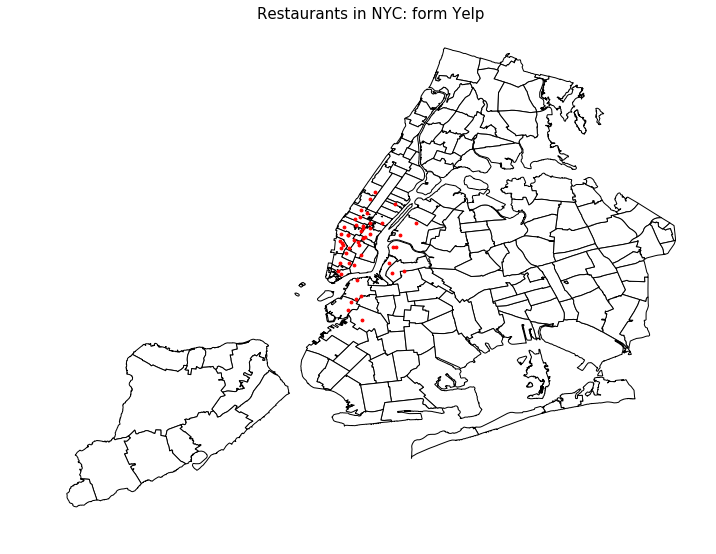

In [141]:
fig = pl.figure(figsize = (12,12))
ax = fig.add_subplot(111)
shp_wgs.plot(ax=ax, color='white', edgecolor='k')
gp.plot(ax=ax, color='red', markersize=8)
ax.axis('off')
pl.title('Restaurants in NYC: form Yelp', fontsize=15);